## Toy MHD and divergence cleaning 


We made a code to check the divergence cleaning strategies discussed in: https://www.overleaf.com/read/phmtkqtkxwjr#baf932

In this version we add the hyperbolic divergence cleaning. Since we are using periodic boundary conditions we don't expect much improvement, because the waves will revolve around,  only the one coming from the damping term. 


### The evolution equations are:

$$
\partial_t B^i = \nabla_j (v^j B^i - v^i B^j) + \kappa \nabla^i (\nabla_j B^j)
$$
for the parabolic case, and

\begin{align*}
\partial_t B^i &= \nabla_j (v^j B^i - v^i B^j) + \nabla^i ψ \\
\partial_t ψ &= c^2 \nabla_j B^j - τψ
\end{align*}


In [39]:
using Plots
using SummationByPartsOperators
using LinearAlgebra
using ArraysOfArrays
using Base.Threads
using Revise
using JLD2
import Pkg; Pkg.add("WriteVTK")
using WriteVTK

includet("../PIC/PIC-1D/aux_functions/aux_functions_grid.jl")
includet("../PIC/PIC-1D/aux_functions/aux_functions_E-B.jl")
includet("../PIC/PIC-1D/aux_functions/aux_functions_RHS.jl")
includet("toy_MHD_auxfunctions.jl")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


Setting the box and the grid coordinates.

In [40]:
J = (200,200)
Box = (0.0,1.0,0.0,1.0)
dx = differentials(Box,J)
const D = 2

xv = [(i-1)*dx[1] for i in 1:J[1]]
yv = [(i-1)*dx[2] for i in 1:J[2]];

The finite differences. 

In [41]:
Dx = periodic_derivative_operator(derivative_order=1, accuracy_order=4, xmin=Box[1], xmax=Box[2], N=J[1])
Dy = periodic_derivative_operator(derivative_order=1, accuracy_order=4, xmin=Box[3], xmax=Box[4], N=J[2])
Δx = dissipation_operator(Dx;
                     #mode=D.coefficients.mode
                     #,mode=ThreadedMode()
                     )
Δy = dissipation_operator(Dy;
                     #mode=D.coefficients.mode
                     #,mode=ThreadedMode()
                     )
σx = 0.0 #dissipation strength
σy = 0.0 #dissipation strength

0.0

Build initial data and velocity field.

In [42]:

x0 = [0.5,0.5]
fv(x,y,k) = sin(k[1]*x)*sin(k[2]*y)
```
bump of radius r and smoothness p around the point x0
```
function fp(x,y,x0,r,p) 
    r20 = r^2
    r2 = (x-x0[1])^2+(y-x0[2])^2
    if r2 - r20 < 0
        return (r20 - r2)^p/r20^p
    else
        return 0.0
    end
end
```
gradient of bump of radius r and smoothness p around the point x0
```
function grad_fp(x,y,x0,r,p)
    r20 = r^2
    r2 = (x-x0[1])^2+(y-x0[2])^2
    if r2 - r20 < 0
        return -2*p*[(x-x0[1]),(y-x0[2])]*(r20 - r2)^(p-1)/r20^p
    else
        return [0.0, 0.0]
    end
end

function polynomial_bump(x,y,p)
    return x^p*(x-1)^p*y^p*(y-1)^p*2^4p
end

poly = [polynomial_bump(x,y,4) for x in xv, y in yv]

#possible V's 

#For really periodic cases we use this one: 

# a sinusoidal one:
#k1 = 2π*[1,1]
#V = [-(l-2)*cos(k1[1]*xv[i]) + (l-1)*cos(k1[2]*yv[j]) for l in 1:2, i in 1:J[1], j in 1:J[2]];

#For one of compact support we use this one: This has problems when used with PINNs because it used `if` statements.
# one from the gradient of a bump function. Because the CFL condition we don't want it to be too big.
#grad_Fp = [grad_fp(xv[i],yv[j],x0,0.45,8)[l] for l in 1:D, i in 1:J[1], j in 1:J[2]];
#V = -0.1*grad_Fp # with 0.1 it is about 1/2 at maximum. 

#To use one that is zero at the boundary we use the following:
# RUN UP TO T=0.4
#=
V = zeros(2,J[1],J[2]);
for i in 1:J[1]
    mul!(view(V,2,i,:), Dy, view(poly,i,:))
end
for j in 1:J[2]
    mul!(view(V,1,:,j), Dx, view(poly,:,j))
end

V = V / maximum(abs.(V))
=#

#Another V which has outgoing flow so no boundary conditions are needed
# RUN UP TO T=2.0
r0 = 0.4
r = [sqrt((xv[i]-0.5)^2+(yv[j]-0.5)^2) for i in 1:J[1], j in 1:J[2]];
V = [-(l-2)*(yv[j]-0.5)*r[i,j]*(r[i,j]-r0) + (l-1)*(xv[i]-0.5)*r[i,j]*(r[i,j]-r0) for l in 1:2, i in 1:J[1], j in 1:J[2]];
V = V / maximum(abs.(V)) * 0.5;


Plot velocity field

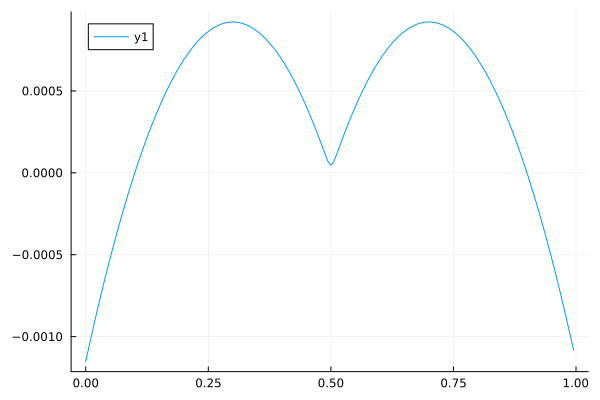

In [43]:
plot(xv,view(V,1,:,J[2]÷2))

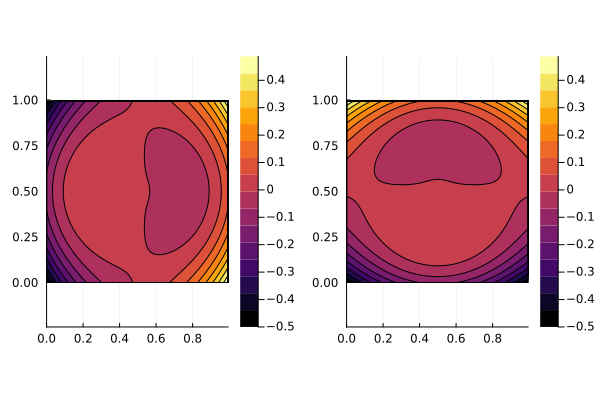

In [44]:
px = plot(yv,xv,V[1,:,:]
, linetype = :contourf
, aspect_ratio = 1
)
py = plot(yv,xv,V[2,:,:]
, linetype = :contourf
, aspect_ratio = 1
)
plot(px,py)

In [45]:

#initial magnetic field

B = zeros(2,J[1],J[2]);
#possible B's
#k2 = 2π*[2,2]
#B = [(l-2)*k2[2]*sin(k2[1]*xv[i])*cos(k2[2]*yv[j]) + (l-1)*k2[1]*cos(k2[1]*xv[i])*sin(k2[2]*yv[j]) for l in 1:2, i in 1:J[1], j in 1:J[2]];
# the following is not working well, the divergence in not zero
#B[1,:,:] = [ (y^3)*(y-1)^3*(2y-1)*(x)^4*(x-1)^4*2^16 for x in xv for y in yv]
#B[2,:,:] = [ -(x^3)*(x-1)^3*(2x-1)*(y)^4*(y-1)^4*2^16 for x in xv for y in yv]

#we also put a violation of div(B)=0 using the same function

eps = 0.0 #10.0^(-5)

poly = [polynomial_bump(x,y,4) for x in xv, y in yv]
@show size(poly)
for i in 1:J[1]
    mul!(view(B,1,i,:), Dy, view(poly,i,:))
    mul!(view(B,2,i,:), Dy, view(poly,i,:), eps)
end
for j in 1:J[2]
    mul!(view(B,2,:,j), -Dx, view(poly,:,j), 1.0)
    mul!(view(B,1,:,j), Dx, view(poly,:,j), eps, 1.0)
end

# pure frequency error 
k2 = 2π*[2,2]
B_error_k = 10^(-5)*[(l-2)*cos(k2[1]*xv[i])*cos(k2[2]*yv[j]) + (l-1)*cos(k2[1]*xv[i])*cos(k2[2]*yv[j]) for l in 1:2, i in 1:J[1], j in 1:J[2]];
B .+= B_error_k;

size(poly) = (200, 200)


Plot initial magnetic field

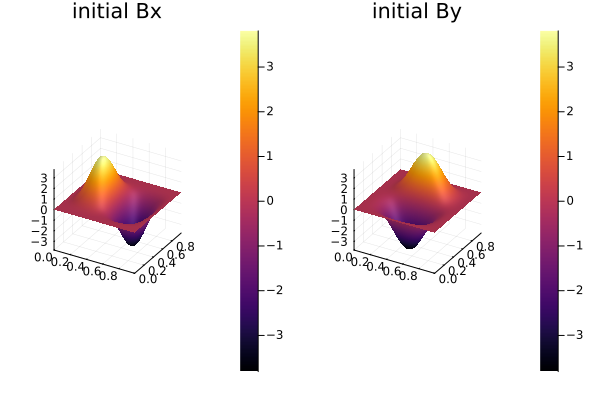

In [46]:
plot(surface(yv,xv,B[1,:,:], title="initial Bx"), surface(yv,xv,B[2,:,:], title="initial By"))

Check the maximum initial constraint violation.

In [47]:
@show maximum(abs.(Div(B,Dx,Dy,J)))

maximum(abs.(Div(B, Dx, Dy, J))) = 0.00012566364551025444


0.00012566364551025444

Plot the initial constraint violation. Notice that it is of high frequency.

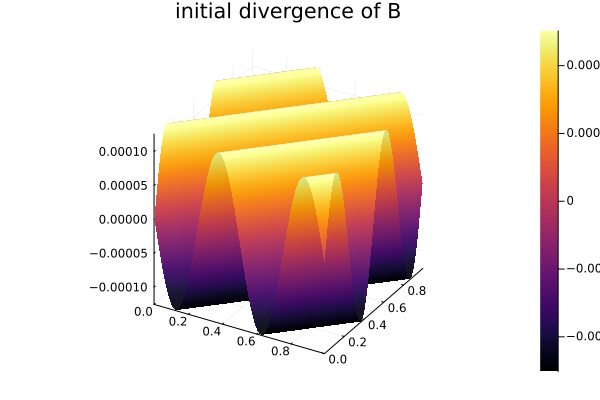

In [48]:
surface(yv,xv,Div(B,Dx,Dy,J), title="initial divergence of B")

Plot the divergence of the velocity field, some times it is important to see where the divergence of the magnetic field will grow.

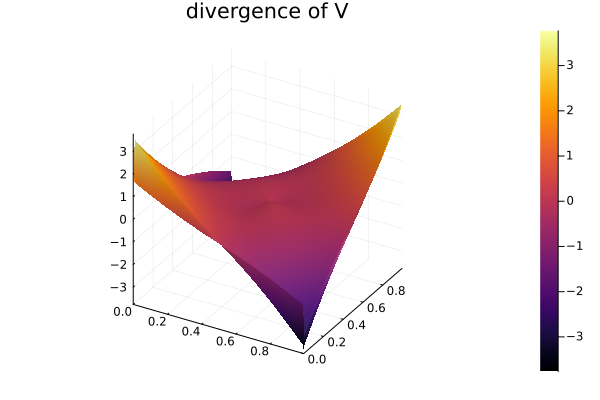

In [49]:
surface(yv,xv,Div(V,Dx,Dy,J), title="divergence of V")

Create the union of evolutionary fields. And location for its time derivatives.

In [50]:
u = Vector{Float64}(undef,(D+1)*J[1]*J[2]); #the last component is psi
du = Vector{Float64}(undef,(D+1)*J[1]*J[2]);

u .= 0.0;
du .= 0.0;

U = reshape(u,D+1,J[1],J[2]);

### Set the method:

In [51]:
#=
hyperbolic = false
parabolic = false
no_div_cleaning = false
hyperbolic = true
#parabolic = true
no_div_cleaning = true
=#
#method = :hyperbolic
method = :parabolic
#method = :no_div_cleaning
@show method

methods = [:no_div_cleaning, :hyperbolic, :parabolic, :mixed]

method = :parabolic


4-element Vector{Symbol}:
 :no_div_cleaning
 :hyperbolic
 :parabolic
 :mixed

In [52]:
function evolve(u,du,V, B_init, method, time_interval, M, par)
    J, Dx, Δx, Dy, Δy, σx, σy, V, κ, c2, τ, du = par
    U[1:D,:,:] .= copy(B_init)
    U[D+1,:,:] .= 0.0 #psi

    if method == :hyperbolic
        κ = 0.0
        c2 = 1.0
        τ = 1.0
    elseif method == :parabolic
        κ = minimum(dx)/2
        c2 = 0.0
        τ = 0.0
    elseif method == :no_div_cleaning
        κ = 0.0
        c2 = 0.0
        τ = 0.0
    elseif method == :mixed
        κ = minimum(dx)/2
        c2 = 1.0
        τ = 1.0
    else
        error("method must be :hyperbolic, :parabolic or :no_div_cleaning")
    end
    (t_i, t_f) = time_interval
    dt = (t_f - t_i)/M

    par = (J, Dx, Δx, Dy, Δy, σx, σy, V, κ, c2, τ, du)

    @show κ, c2, τ, dt/maximum(dx)
    #set initial values
    Energy = Array{Float64,1}(undef,M+1)
    Div_B_max = Array{Float64,1}(undef,M+1)
    Div_B_L2 = Array{Float64,1}(undef,M+1)
    tt = Array{Float64,1}(undef,M+1)
    @show Energy[1] = get_Energy(u,J,Box)
    @show Div_B_max[1] = maximum(abs.(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J)))
    @show Div_B_L2[1] = norm(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J))*sqrt(volume(Box)/prod(J))
    tt[1] = t_i
    t = t_i
    
    for i in 1:M
        #=
        if method == :hyperbolic || method == :no_div_cleaning
            RK4_Step!(F_hyp!, u, 0.0, dt, par)
        elseif method == :parabolic
            RK4_Step!(F_par!, u, 0.0, dt, par)
        end
        =#
        RK4_Step!(F_total!, u, 0.0, dt, par)

        t = t + dt
        tt[i+1] = t
    
        Energy[i+1] = get_Energy(u,J,Box)
        Div_B_max[i+1] = maximum(abs.(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J)))
        Div_B_L2[i+1] = norm(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J))*sqrt(volume(Box)/prod(J))

        #println("t = $t")
        #println("Energy = $(get_Energy(u,J,Box))")
        #println("DivB = $(maximum(abs.(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J))))")
    
end
    return u, Energy, Div_B_max, Div_B_L2, tt
end

evolve (generic function with 1 method)

In [53]:
#method = :hyperbolic
method = :parabolic
#method = :no_div_cleaning
time_interval = (0.0, 0.2)
M = 40
κ = minimum(dx)/2
c2 = 1.0
τ = 1.0
par = (J, Dx, Δx, Dy, Δy, σx, σy, V, κ, c2, τ, du)
u_final, Energy, Div_B_max, Div_B_L2, tt = evolve(u,du,V,B,method, time_interval, M,par)

(κ, c2, τ, dt / maximum(dx)) = (0.0025, 0.0, 0.0, 1.0)
Energy[1] = get_Energy(u, J, Box) = 3.48638788743661
Div_B_max[1] = maximum(abs.(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J))) = 0.00012566364551025444
Div_B_L2[1] = norm(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J)) * sqrt(volume(Box) / prod(J)) = 8.885761262174717e-5


([-0.0005733402919931358, 0.0005733402919931361, 0.0, -0.0016191927418703614, -0.000446435766927761, 0.0, -0.0019547611750273344, -0.0005773161671309642, 0.0, -0.0020234663056045636  …  0.0, 0.0018538939553168713, 0.0004468264792062066, 0.0, 0.001523944904567464, 0.00032617923067712514, 0.0, 0.0006151678541806705, -0.000615167854180671, 0.0], [3.48638788743661, 3.486394054346111, 3.4864125550920835, 3.4864433897257054, 3.4864865583317792, 3.486542061029525, 3.4866098979718494, 3.4866900693459115, 3.4867825753729247, 3.4868874163084365  …  3.4923155991635095, 3.4927042924469287, 3.4931053370956833, 3.493518734228795, 3.4939444850000108, 3.494382590596976, 3.494833052241789, 3.495295871190404, 3.495771048732062, 3.496258586189749], [0.00012566364551025444, 0.0001251685209764375, 0.00012467534909443856, 0.00012418412103132326, 0.0001236948285638917, 0.00012320746404848038, 0.0001227220198094514, 0.0001222384882857419, 0.00012175686188875545, 0.00012127713308718313  …  0.000111188377120541

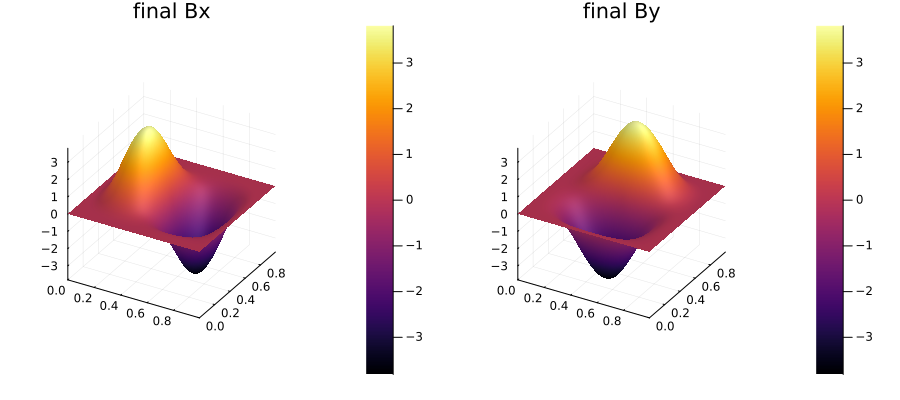

In [54]:
pBx = surface(yv,xv,reshape(u_final,(D+1,J...))[1,:,:], title="final Bx")
pBy = surface(yv,xv,reshape(u_final,(D+1,J...))[2,:,:], title="final By")

plot(pBx, pBy, size=(900,400))

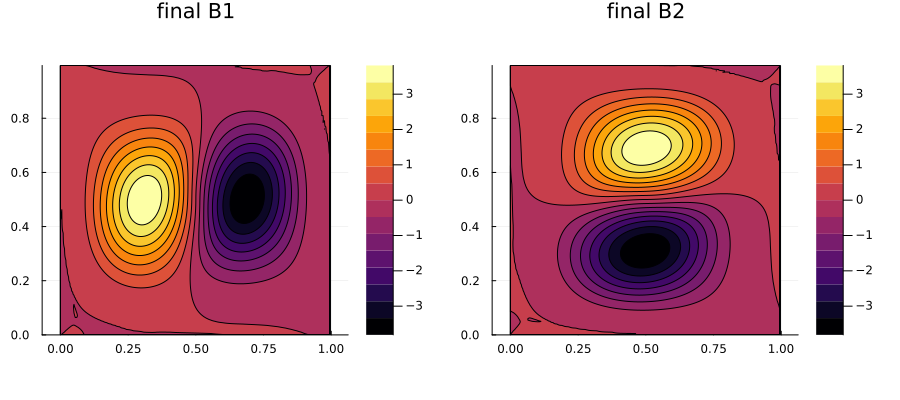

In [55]:
ps = []
for i in 1:2
    p1 = plot(yv, xv, reshape(u_final,(D+1,J...))[i,:,:], title="final B$i"
        ,linetype = :contourf
        #st = :surface,
        , aspect_ratio = 1)
    push!(ps, p1)
end

plot(ps[1], ps[2], layout = (1,2), size= (900,400))#linetype = :contourf, 
        

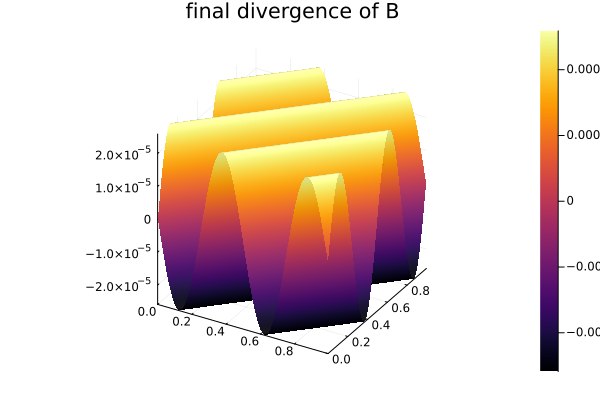

In [74]:
surface(yv,xv,Div(reshape(u_final,(D+1,J...))[1:D, :, :],Dx,Dy,J), title="final divergence of B")

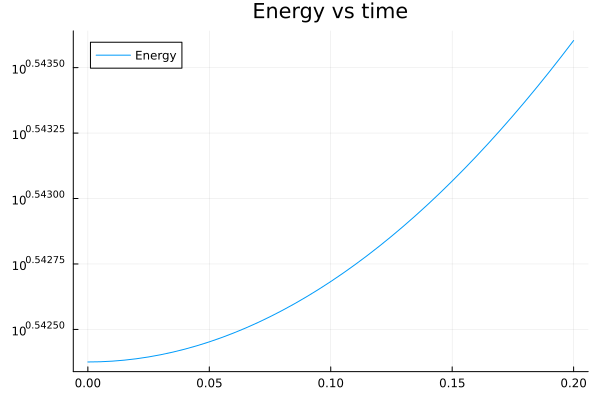

In [57]:
plot(tt,Energy, yaxis=:log, title="Energy vs time", label="Energy")

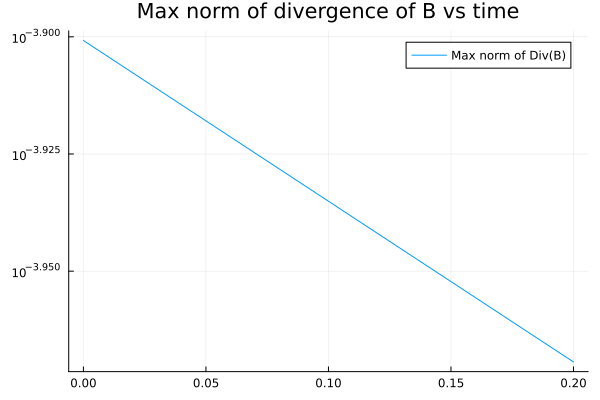

In [58]:
plot(tt, Div_B_max, yaxis=:log, title="Max norm of divergence of B vs time", label="Max norm of Div(B)")

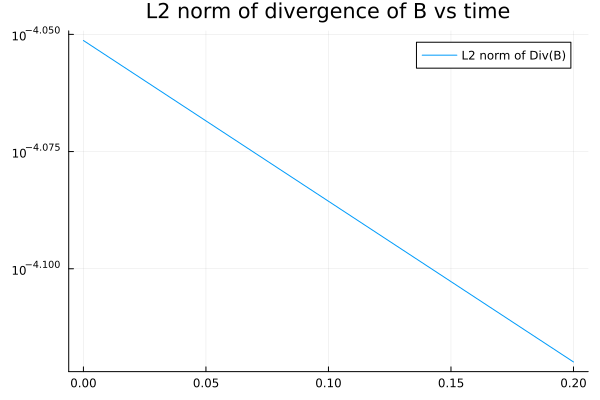

In [59]:
plot(tt, Div_B_L2, yaxis=:log, title="L2 norm of divergence of B vs time", label="L2 norm of Div(B)")

## Now all methods together

Evolving with method = no_div_cleaning
(κ, c2, τ, dt / maximum(dx)) = (0.0, 0.0, 0.0, 1.0)
Energy[1] = get_Energy(u, J, Box) = 3.48638788743661
Div_B_max[1] = maximum(abs.(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J))) = 0.00012566364551025444
Div_B_L2[1] = norm(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J)) * sqrt(volume(Box) / prod(J)) = 8.885761262174717e-5
Evolving with method = hyperbolic
(κ, c2, τ, dt / maximum(dx)) = (0.0, 1.0, 1.0, 1.0)
Energy[1] = get_Energy(u, J, Box) = 3.48638788743661
Div_B_max[1] = maximum(abs.(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J))) = 0.00012566364551025444
Div_B_L2[1] = norm(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J)) * sqrt(volume(Box) / prod(J)) = 8.885761262174717e-5
Evolving with method = parabolic
(κ, c2, τ, dt / maximum(dx)) = (0.0025, 0.0, 0.0, 1.0)
Energy[1] = get_Energy(u, J, Box) = 3.48638788743661
Div_B_max[1] = maximum(abs.(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J))) = 0.00012566364

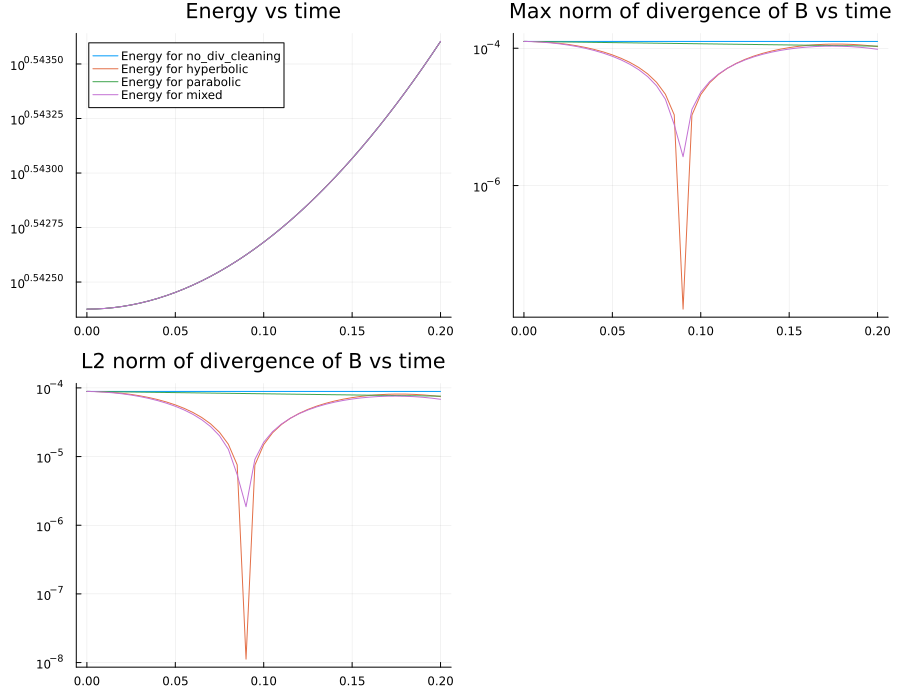

In [60]:
p_E = plot()
p_Div_max = plot()
p_Div_L2 = plot()

for method in methods
    println("Evolving with method = $method")
    u_final, Energy, Div_B_max, Div_B_L2, tt = evolve(u,du,V,B,method, time_interval, M,par)
    plot!(p_E,tt,Energy, yaxis=:log, title="Energy vs time", label="Energy for $method")
    plot!(p_Div_max,tt, Div_B_max, yaxis=:log, title="Max norm of divergence of B vs time", label="Max norm of Div(B) for $method", legend=:false)
    plot!(p_Div_L2,tt, Div_B_L2, yaxis=:log, title="L2 norm of divergence of B vs time", label="L2 norm of Div(B) for $method", legend=:false)
end

plot(p_E, p_Div_max, p_Div_L2, layout = (2,2), size=(900,700))
#savefig("comparison_div_cleaning_methods_error_k02.png")

![try_1 comparison](comparison_div_cleaning_methods.png)

# Old material, superseeded

### Set the initial data.

B === (reshape(u, (D + 1, J...)))[1:D, :, :] = false
norm(B - (reshape(u, (D + 1, J...)))[1:D, :, :]) = 0.0
maximum(abs.(u)) = 3.808173119219729
get_Energy(u, J, Box) = 3.48638788743661
maximum(abs.(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J))) = 0.00012566364551025444
typeof(u) = Vector{Float64}
typeof(F_par!(u, 0.0, (J, Dx, Δx, Dy, Δy, σx, σy, V, 0.1, 1.0, 1.0, du))) = Vector{Float64}


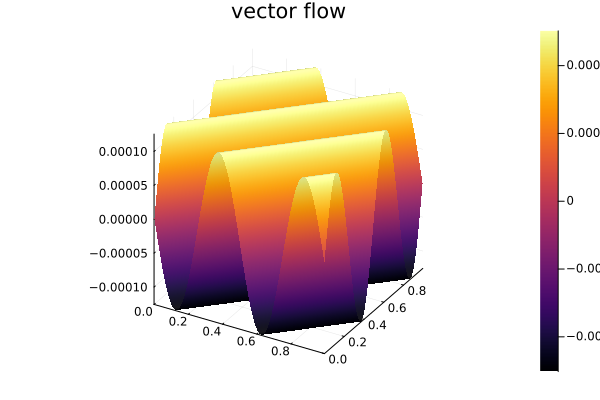

In [61]:
U[1:D,:,:] .= copy(B)
U[D+1,:,:] .= 0.0 #psi
@show B === reshape(u,(D+1,J...))[1:D,:,:]
@show norm(B - reshape(u,(D+1,J...))[1:D,:,:])
@show maximum(abs.(u))
@show get_Energy(u,J,Box)
@show maximum(abs.(Div(reshape(u,(D+1,J...))[1:D,:,:],Dx,Dy,J)))

@show typeof(u)
if method == :hyperbolic || method == :no_div_cleaning
@show typeof(F_hyp!(u,0.0,(J, Dx, Δx, Dy, Δy, σx, σy, V, 0.1, 1.0, 1.0, du)))
surface(yv,xv,reshape(F_hyp!(u,0.0,(J, Dx, Δx, Dy, Δy, σx, σy, zeros(D,J...), 0.1, 1, 1, du)),D+1,J...)[3,:,:], title="vector flow")
elseif method == :parabolic
@show typeof(F_par!(u,0.0,(J, Dx, Δx, Dy, Δy, σx, σy, V, 0.1, 1.0, 1.0, du)))
surface(yv,xv,reshape(F_hyp!(u,0.0,(J, Dx, Δx, Dy, Δy, σx, σy, zeros(D,J...), 0.1, 1, 1, du)),D+1,J...)[3,:,:], title="vector flow")
end
#surface(yv,xv,du[2,:,:])

### Set the evolution parameters:

In [62]:
(t_i, t_f) = (0.0, 1.0)
M = 400
@show dt = (t_f - t_i)/M
@show differentials(Box,J)

if method == :hyperbolic 
      κ = 0.0
      c2 = 1.0
      τ = 1.0
elseif method == :parabolic
      κ = maximum(dx) # we scale the dissipation with the grid size so that it does not changes the CFL factor.
      c2 = 0.0
      τ = 0.0
end

if method == :no_div_cleaning
      κ = 0.0
      c2 = 0.0
      τ = 0.0
end



@show κ, c2, τ
par = (J, Dx, Δx, Dy, Δy, σx, σy, V, κ, c2, τ, du)
t = t_i
Energy = Array{Float64,1}(undef,M+1)
Div_B_max = Array{Float64,1}(undef,M+1)
Div_B_L2 = Array{Float64,1}(undef,M+1)
tt = Array{Float64,1}(undef,M+1)
@show Energy[1] = get_Energy(u,J,Box)
@show Div_B_max[1] = maximum(abs.(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J)))
@show Div_B_L2[1] = norm(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J))*sqrt(volume(Box)/prod(J))
tt[1] = t;

dt = (t_f - t_i) / M = 0.0025
differentials(Box, J) = [0.005, 0.005]
(κ, c2, τ) = (0.005, 0.0, 0.0)
Energy[1] = get_Energy(u, J, Box) = 3.48638788743661
Div_B_max[1] = maximum(abs.(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J))) = 0.00012566364551025444
Div_B_L2[1] = norm(Div((reshape(u, (D + 1, J...)))[1:D, :, :], Dx, Dy, J)) * sqrt(volume(Box) / prod(J)) = 8.885761262174717e-5


In [63]:
@show κ, c2, τ, dt/maximum(dx)

(κ, c2, τ, dt / maximum(dx)) = (0.005, 0.0, 0.0, 0.5)


(0.005, 0.0, 0.0, 0.5)

In [64]:
for i in 1:M
    if method == :hyperbolic || method == :no_div_cleaning
        RK4_Step!(F_hyp!, u, 0.0, dt, par)
    elseif method == :parabolic
        RK4_Step!(F_par!, u, 0.0, dt, par)
    end
    t = t + dt
    tt[i+1] = t
    
    Energy[i+1] = get_Energy(u,J,Box)
    Div_B_max[i+1] = maximum(abs.(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J)))
    Div_B_L2[i+1] = norm(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J))*sqrt(volume(Box)/prod(J))

    println("t = $t")
    println("Energy = $(get_Energy(u,J,Box))")
    println("DivB = $(maximum(abs.(Div(reshape(u,(D+1,J...))[1:D, :, :],Dx,Dy,J))))")
    
end

t = 0.0025
Energy = 3.4863894291635202
DivB = 0.00012516852099553333
t = 0.005
Energy = 3.4863940543458245
DivB = 0.0001246753491175312
t = 0.0075
Energy = 3.486401762986773
DivB = 0.00012418412102821463
t = 0.01
Energy = 3.4864125550916802
DivB = 0.00012369482852081504
t = 0.0125
Energy = 3.4864264306678217
DivB = 0.00012320746400984461
t = 0.015000000000000001
Energy = 3.4864433897250855
DivB = 0.0001227220197561607
t = 0.0175
Energy = 3.4864634322748227
DivB = 0.00012223848822934258
t = 0.02
Energy = 3.4864865583310616
DivB = 0.0001217568618621101
t = 0.0225
Energy = 3.4865127679096
DivB = 0.00012127713307652499
t = 0.024999999999999998
Energy = 3.4865420610285933
DivB = 0.00012079929447317284
t = 0.027499999999999997
Energy = 3.4865744377081587
DivB = 0.00012032333857447952
t = 0.029999999999999995
Energy = 3.4866098979707
DivB = 0.0001198492579908006
t = 0.032499999999999994
Energy = 3.486648441840651
DivB = 0.00011937704528364179
t = 0.034999999999999996
Energy = 3.48669006934463

In [65]:
#It works in Paraview but not in VisIt
vtk_grid("u", xv, yv) do vtk
    vtk["B"] = @views reshape(u,(D+1,J...))[1:D, :, :]        # Magnetic field attached to points
    vtk["ψ"] = @views reshape(u,(D+1,J...))[3, :, :]     # scalar field attached to cells
    vtk["Velocity"] = V            # vector field attached to points
    vtk["TimeValue"] = tt[M+1]                           # metadata ("field data" in VTK)
end

1-element Vector{String}:
 "u.vtr"

The ψ field:

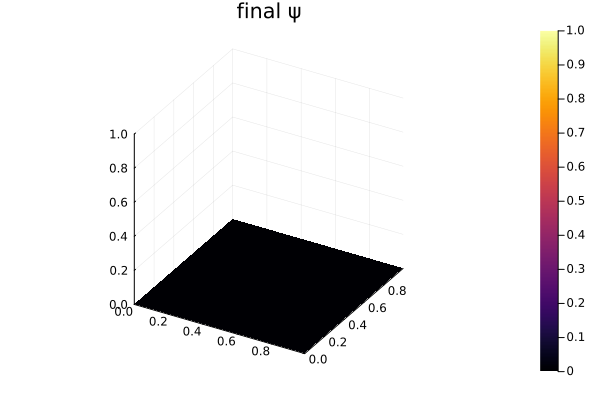

In [66]:
surface(yv,xv,reshape(u,(D+1,J...))[3, :, :], title="final ψ")

The magnetic field:

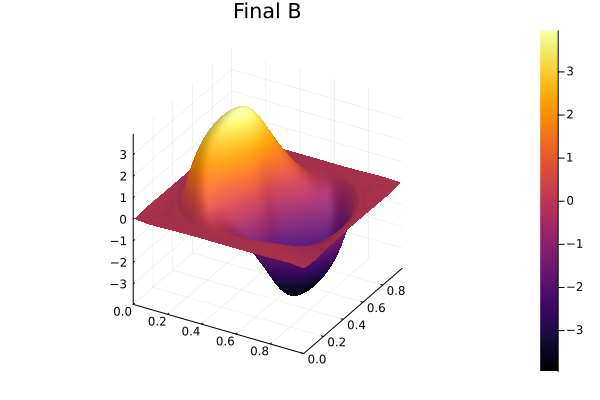

In [67]:
surface(yv,xv,reshape(u_final,(D+1,J...))[1, :, :], title="Final B")

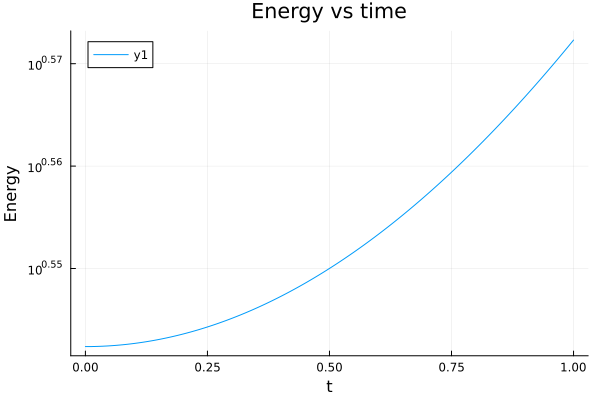

In [68]:
plot(tt, Energy, yscale=:log10, title="Energy vs time", xlabel="t", ylabel="Energy")

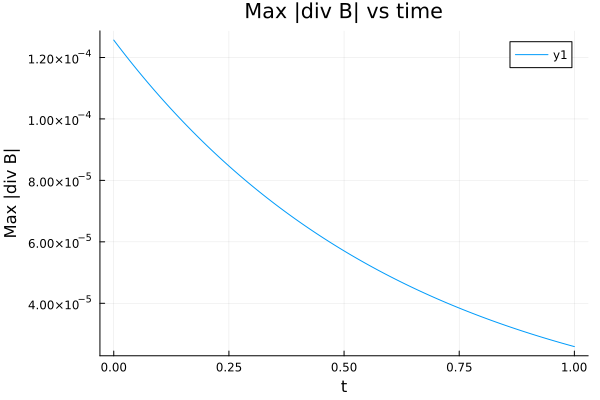

In [69]:
plot(tt, Div_B_max,title="Max |div B| vs time",xlabel="t",ylabel="Max |div B|")

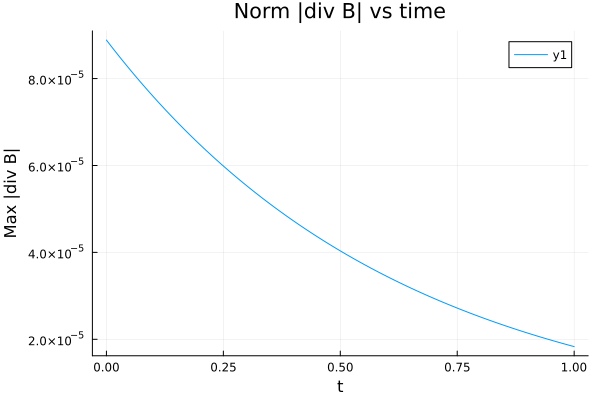

In [70]:
plot(tt, Div_B_L2,title="Norm |div B| vs time",xlabel="t",ylabel="Max |div B|")

### Comparison:

We compare both cleaning methods against themselves and the free, no-cleaning evolution.

In [71]:

if method == :no_div_cleaning 
    Div_B_max_0 = copy(Div_B_max); #for no div control.
    Div_B_L2_0 = copy(Div_B_L2);
else
    if method == :hyperbolic
        Div_B_max_1_1 = copy(Div_B_max);
        Div_B_L2_1_1 = copy(Div_B_L2);
    elseif method == :parabolic
        Div_B_max_1 = copy(Div_B_max);
        Div_B_L2_1 = copy(Div_B_L2);
    end
end


401-element Vector{Float64}:
 8.885761262174717e-5
 8.85075087235609e-5
 8.815878425407901e-5
 8.78114337784233e-5
 8.746545188253058e-5
 8.712083317465575e-5
 8.677757228327502e-5
 8.643566385900471e-5
 8.609510257256837e-5
 8.575588311656227e-5
 ⋮
 1.8906066842690025e-5
 1.8831575895885772e-5
 1.8757378447447263e-5
 1.8683473341108504e-5
 1.8609859424861888e-5
 1.85365355515575e-5
 1.8463500578248645e-5
 1.8390753367039273e-5
 1.8318292783707523e-5

We observe that in $L^2$ norm both the non-cleaning and the hyperbolic methods grow. The hyperbolic does a good job in holding the violation small. But the parabolic methods works much better, keeping the violation to a better level than what it was originally. 
If we increase the τ value to 100 then the hyperbolic method works in a very similar way as the parabolic one. 

**Warning:** in these simulations the magnetic field evolves very high frequencies very quickly and already the last part of the computation does not resolves the solution very well. Even though the constraint violation stays small.

In [72]:
plot(tt,Div_B_L2_0, title="Norm |div B| vs time D-order=4",xlabel="t",ylabel="Norm |div B|", label="κ=0.0, c2 = 0.0, τ = 0.0", yscale=:log10)
plot!(tt,Div_B_L2_1_1, label="κ = 0.0, c2=1, τ=100")
plot!(tt,Div_B_L2_1, label="κ=1, c2= 0.0, τ=0")
#savefig("DivB_L2_vs_time_D-order=4_bump_neg_tau100.png")

UndefVarError: UndefVarError: `Div_B_L2_0` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

![DivB_L2_vs_time](DivB_L2_vs_time_D-order=4_bump_neg.png)
![DivB_L2_vs_time](DivB_L2_vs_time_D-order=4_bump_neg_tau100.png)

In the maximum norm we observe something similar. 

In [73]:
plot(tt,Div_B_max_0, title="Max |div B| vs time D-order=4",xlabel="t",ylabel="Max |div B|", label="c2=0.0", yscale=:log10)
plot!(tt,Div_B_max_1_1, label="c2=1 τ=100")
plot!(tt,Div_B_max_1, label="κ=1 τ=0")
#savefig("DivB_max_vs_time_D-order_bump_neg_tau100=4.png")

UndefVarError: UndefVarError: `Div_B_max_0` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

![DivB_max_vs_time](DivB_max_vs_time_D-order_bump_neg=4.png)
![DivB_max_vs_time](DivB_max_vs_time_D-order_bump_neg_tau100=4.png)
